In [8]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import safeopt
# from safeopt.multi_agent import safeopt.MAGPRegression

mpl.rcParams['figure.figsize'] = (20.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 20

## Define a kernel and function

Here we define a kernel. The function is drawn at random from the GP and is corrupted my Gaussian noise

In [9]:
# Measurement noise
noise_var = 0.05 ** 2
noise_var2 = 1e-5

# Bounds on the inputs variable
bounds = [(-10., 10.)]

# Define Kernel
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)
kernel2 = kernel.copy()

# set of parameters
parameter_set = safeopt.linearly_spaced_combinations(bounds, 1000)

# Initial safe point
x0 = np.zeros((1, len(bounds)))

In [10]:
# Generate function with safe initial point at x=0
# def sample_safe_fun():
#     fun = safeopt.sample_gp_function(kernel, bounds, noise_var, 100)
#     while True:
#         fun2 = safeopt.sample_gp_function(kernel2, bounds, noise_var2, 100)
#         if fun2(0, noise=False) > 1:
#             break
#
#     def combined_fun(x, noise=True):
#         return np.hstack([fun(x, noise), fun2(x, noise)])
#     return combined_fun

In [11]:
# Generate function with safe initial point at x=0
def sample_safe_fun():
    fun = lambda x: (x - 1.)*np.sin(x - 0.5)
    fun2 = lambda x: (x - 1.)*np.sin(x - 0.5)

    def combined_fun(x, noise=True):
        return np.hstack([fun(x), fun2(x)])
    return combined_fun



# Communication network
# N = np.eye(3)
# N[0,1] = N[1,0] = N[1,2] = N[2,1] = 1
N = np.ones([2, 2])

## Interactive run of the algorithm

In [12]:
# Define the objective function
fun = sample_safe_fun()

# The statistical model of our objective function and safety constraint
y0 = fun(x0)
gp00 = safeopt.MAGPRegression(x0, y0[:, 0, None], kernel, noise_var=noise_var)
gp01 = safeopt.MAGPRegression(x0, y0[:, 1, None], kernel2, noise_var=noise_var2)
gp10 = safeopt.MAGPRegression(x0, y0[:, 0, None], kernel, noise_var=noise_var)
gp11 = safeopt.MAGPRegression(x0, y0[:, 1, None], kernel2, noise_var=noise_var2)
gp20 = safeopt.MAGPRegression(x0, y0[:, 0, None], kernel, noise_var=noise_var)
gp21 = safeopt.MAGPRegression(x0, y0[:, 1, None], kernel2, noise_var=noise_var2)

# The optimization routine
# opt = safeopt.SafeOptSwarm([gp, gp2], [-np.inf, 0.], bounds=bounds, threshold=0.2)
# opt = safeopt.SafeOpt([gp, gp2], parameter_set, [-np.inf, 0.], lipschitz=None, threshold=0.1)
maopt = safeopt.MultiAgentSafeOptSwarm(N, fun, [[gp00,gp01],[gp10, gp11], [gp20, gp21]], [-np.inf, 0.], bounds=bounds, threshold=0.2)

In [13]:
def plot(agent_id):
    # Plot the GP
    maopt.agents[agent_id].plot(100)
    # Plot the true function
    y = fun(parameter_set, noise=False) # parameter_set is just a list of x
    for manager, true_y in zip(mpl._pylab_helpers.Gcf.get_all_fig_managers(), y.T):
        figure = manager.canvas.figure
        figure.gca().plot(parameter_set, true_y, color='C2', alpha=0.3)

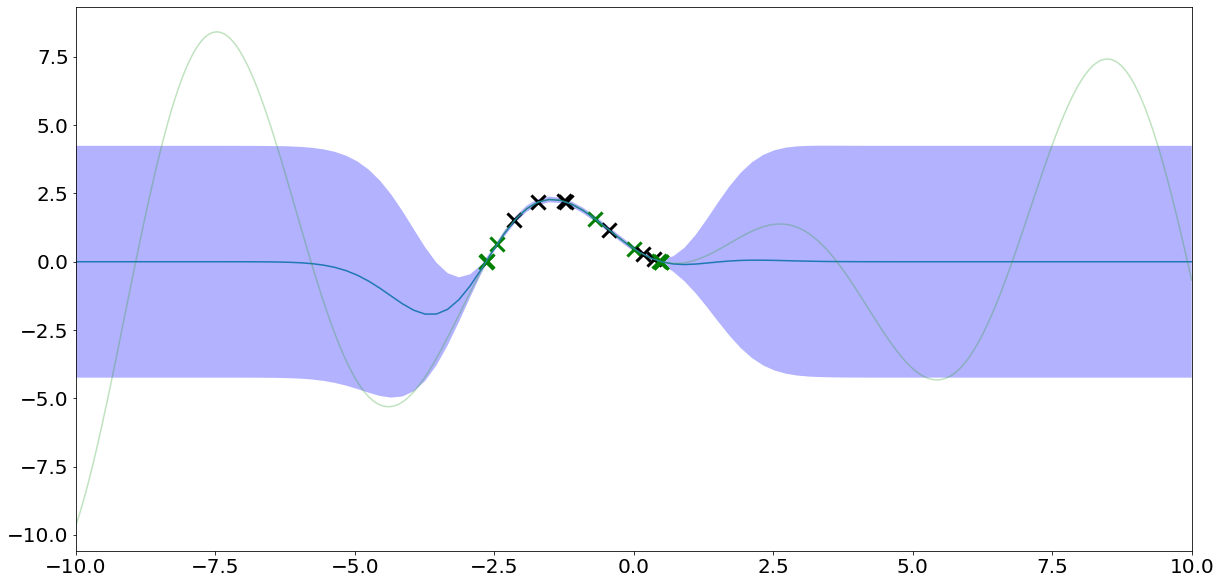

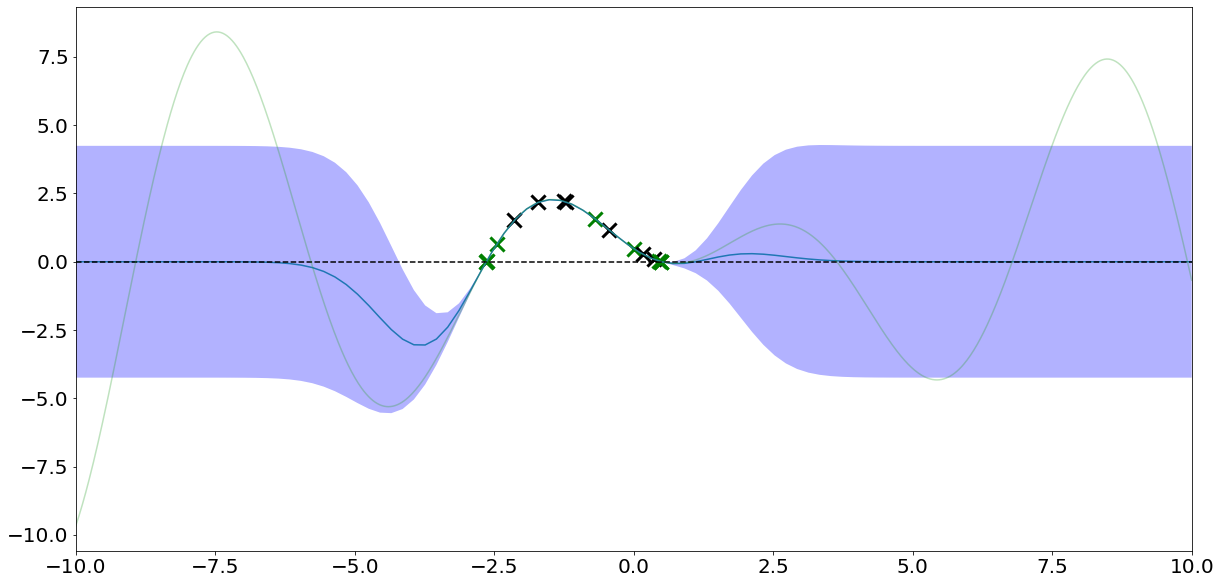

In [20]:
maopt.optimize_with_different_tasks()

plot(0)

In [ ]:
plot(1)


In [ ]:
# Obtain next query point
maopt.optimize()
# Get a measurement from the real system
# y_meas = fun(x_next)
# # Add this to the GP model
# opt.add_new_data_point(x_next, y_meas)

plot(0)